## Results analysis of risky selection 

July 29, 2021 - Sundong

* Motivation
    * Brian raises an issue that risky-profile based sampling itself outperforms xgb and other graph-based strategy.
    * The naive idea - ```RiskProfileSampling``` mark the trades' suspiciousness by the summation of all the calculated risky profiles. 
    * So, I implemented ```RiskProfileSampling``` and placed it in ```query_strategy/risky.py```.
    * Then, compared the performance between ```RiskProfileSampling``` and other strategies; xgb and random.
    
    
* Setting
    * 3-time averaged performance of random, risky, xgb selection strategies
    * risky uses 'ratio' option for risk profiling, xgb uses default 'topk' option for risk profiling 
    * Training set for the first round: 3 months, 10% of its labels are retained, rest are masked. 
    * Validation length: The last 15 days of the training set.
    * Testing: Next 15 days for each episode
    * Simulation is ended when it reaches the end of the dataset, or 100 episodes. (~ 1500 days)



* Example script for the synthetic data
   * Bash scripts can be found in: ```bash/risky/risky-*.sh```

```
sleep 5
python main.py --data synthetic --prefix risky2 --batch_size 128 --sampling random --mode scratch --train_from 20130101 --test_from 20130331 --test_length 15 --valid_length 15 --initial_inspection_rate 10 --final_inspection_rate 10 --epoch 2 --closs bce --rloss full --save 0 --numweeks 100 --inspection_plan direct_decay --initial_masking importer &

sleep 5
python main.py --data synthetic --prefix risky2 --batch_size 128 --sampling risky --risk_profile ratio --mode scratch --train_from 20130101 --test_from 20130331 --test_length 15 --valid_length 15 --initial_inspection_rate 10 --final_inspection_rate 10 --epoch 2 --closs bce --rloss full --save 0 --numweeks 100 --inspection_plan direct_decay --initial_masking importer &

sleep 5
python main.py --data synthetic --prefix risky2 --batch_size 128 --sampling xgb --mode scratch --train_from 20130101 --test_from 20130331 --test_length 15 --valid_length 15 --initial_inspection_rate 10 --final_inspection_rate 10 --epoch 2 --closs bce --rloss full --save 0 --numweeks 100 --inspection_plan direct_decay --initial_masking importer &

```

In [1]:
import numpy as np
import pandas as pd
import glob 
import csv
import traceback
import datetime
import os
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
pd.options.display.max_columns=50


def draw(prefix, metric, dataset):
    results = glob.glob(f'../results/performances/{prefix}-*')   # quick- or www21- or fld-
    list1, list2 = zip(*sorted(zip([os.stat(result).st_size for result in results], results)))

    full_results = defaultdict(list)
    # Retrieving results
    num_logs = len([i for i in list1 if i > 1000])
    count= 0
    for i in range(1,num_logs+1):
        try:
            df = pd.read_csv(list2[-i])
            rolling_mean7 = df[metric].rolling(window=7).mean()
            rolling_mean13 = df[metric].rolling(window=13).mean()
            filename = list2[-i][list2[-i].index('16'):list2[-i].index('16')+10]
            info = ','.join(list(df[['data', 'sampling', 'subsamplings']].iloc[0]))
            full_results[info].append(rolling_mean7)
            count += 1
        except:
            print('loading error:', list2[-i])
            continue
    
    plt.figure()
    result_one_dataset = [key for key in full_results.keys() if dataset+',' in key]
    print(result_one_dataset)
    print('The number of trials for each setting (Results are averaged):')
    for key in result_one_dataset:
        avg_result = pd.concat([*full_results[key]], axis=1).mean(axis=1)
    #     print(pd.concat([*full_results[key]], axis=1))   # Check current running status: debug purpose
        print(key, len(full_results[key]), round(np.mean(avg_result[-1:]), 4))
        plt.plot(avg_result.index, avg_result, label=key)

    # # printing test_illicit_rate
    # tir = pd.read_csv(list2[-1])['test_illicit_rate'].rolling(window=7).mean()
    # plt.plot(tir.index, tir, label='Test illicit rate (ref)')

    plt.title(f'{dataset}: Train: 90 days, Valid: 15 days, Test: 15 days')
    plt.legend(loc='lower left')
    plt.ylabel(metric)
    plt.xlabel('numEpisodes')
    plt.ylim(0, 1.02)
    plt.show()
    plt.close()

### Synthetic results (Performance: risky > xgb > random)

In [2]:
prefix = 'risky3'

['synthetic,random,-', 'synthetic,risky,-', 'synthetic,xgb,-']
The number of trials for each setting (Results are averaged):
synthetic,random,- 3 0.1011
synthetic,risky,- 3 0.3105
synthetic,xgb,- 3 0.1973


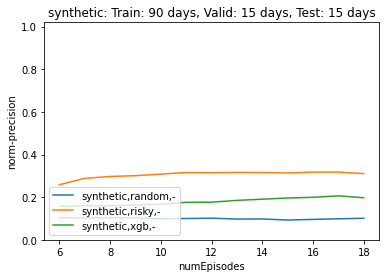

In [3]:
draw(prefix=prefix, metric='norm-precision', dataset='synthetic')

['synthetic,random,-', 'synthetic,risky,-', 'synthetic,xgb,-']
The number of trials for each setting (Results are averaged):
synthetic,random,- 3 0.1011
synthetic,risky,- 3 0.3105
synthetic,xgb,- 3 0.1973


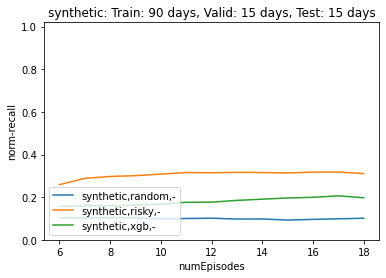

In [4]:
draw(prefix=prefix, metric='norm-recall', dataset='synthetic')

['synthetic,random,-', 'synthetic,risky,-', 'synthetic,xgb,-']
The number of trials for each setting (Results are averaged):
synthetic,random,- 3 0.1011
synthetic,risky,- 3 0.3341
synthetic,xgb,- 3 0.2072


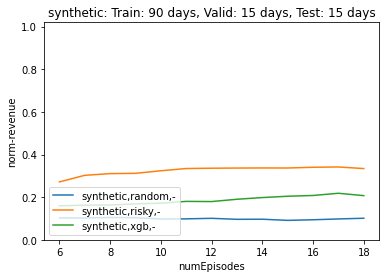

In [5]:
draw(prefix=prefix, metric='norm-revenue', dataset='synthetic')

### Synthetic-k results (Performance: xgb > risky > random)

['synthetic-k,random,-', 'synthetic-k,risky,-', 'synthetic-k,xgb,-']
The number of trials for each setting (Results are averaged):
synthetic-k,random,- 3 0.2296
synthetic-k,risky,- 3 0.5242
synthetic-k,xgb,- 3 0.4413


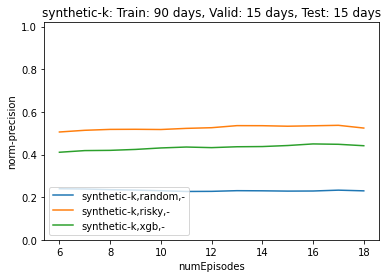

In [6]:
draw(prefix=prefix, metric='norm-precision', dataset='synthetic-k')

['synthetic-k,random,-', 'synthetic-k,risky,-', 'synthetic-k,xgb,-']
The number of trials for each setting (Results are averaged):
synthetic-k,random,- 3 0.2296
synthetic-k,risky,- 3 0.5242
synthetic-k,xgb,- 3 0.4413


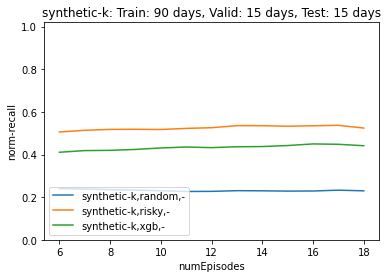

In [7]:
draw(prefix=prefix, metric='norm-recall', dataset='synthetic-k')

['synthetic-k,random,-', 'synthetic-k,risky,-', 'synthetic-k,xgb,-']
The number of trials for each setting (Results are averaged):
synthetic-k,random,- 3 0.1068
synthetic-k,risky,- 3 0.27
synthetic-k,xgb,- 3 0.2304


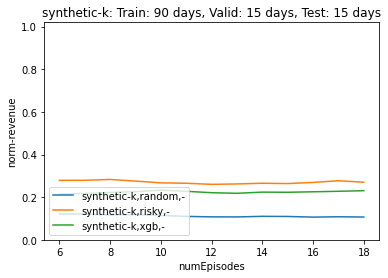

In [8]:
draw(prefix=prefix, metric='norm-revenue', dataset='synthetic-k')

### real-m results (Performance: xgb > risky > random)

['real-m,random,-', 'real-m,risky,-', 'real-m,xgb,-']
The number of trials for each setting (Results are averaged):
real-m,random,- 3 nan
real-m,risky,- 3 nan
real-m,xgb,- 3 nan


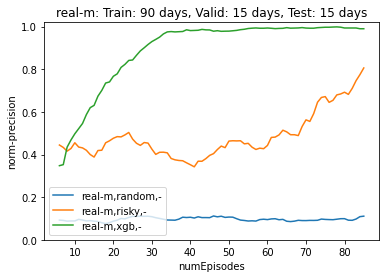

In [9]:
draw(prefix=prefix, metric='norm-precision', dataset='real-m')

['real-m,random,-', 'real-m,risky,-', 'real-m,xgb,-']
The number of trials for each setting (Results are averaged):
real-m,random,- 3 nan
real-m,risky,- 3 nan
real-m,xgb,- 3 nan


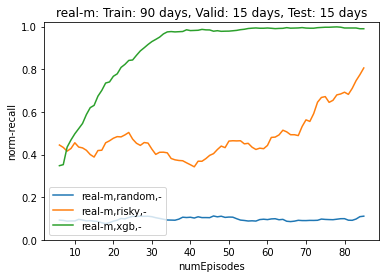

In [10]:
draw(prefix=prefix, metric='norm-recall', dataset='real-m')

['real-m,random,-', 'real-m,risky,-', 'real-m,xgb,-']
The number of trials for each setting (Results are averaged):
real-m,random,- 3 nan
real-m,risky,- 3 nan
real-m,xgb,- 3 nan


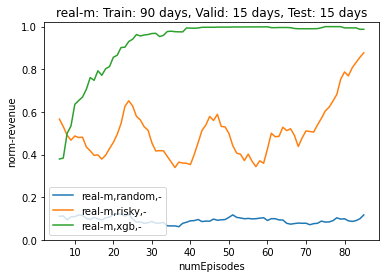

In [11]:
draw(prefix=prefix, metric='norm-revenue', dataset='real-m')

### real-c results (Performance: risky > xgb > random)

['real-c,random,-', 'real-c,risky,-', 'real-c,xgb,-']
The number of trials for each setting (Results are averaged):
real-c,random,- 9 0.1004
real-c,risky,- 3 0.3276
real-c,xgb,- 3 0.2035


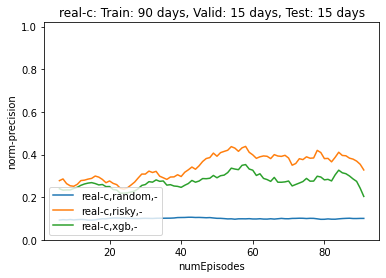

In [12]:
draw(prefix=prefix, metric='norm-precision', dataset='real-c')

['real-c,random,-', 'real-c,risky,-', 'real-c,xgb,-']
The number of trials for each setting (Results are averaged):
real-c,random,- 9 0.1004
real-c,risky,- 3 0.3276
real-c,xgb,- 3 0.2035


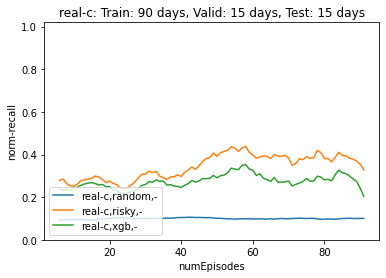

In [13]:
draw(prefix=prefix, metric='norm-recall', dataset='real-c')

['real-c,random,-', 'real-c,risky,-', 'real-c,xgb,-']
The number of trials for each setting (Results are averaged):
real-c,random,- 9 0.11
real-c,risky,- 3 0.4985
real-c,xgb,- 3 0.3212


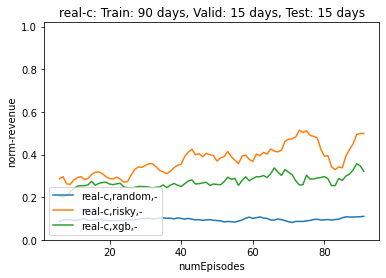

In [14]:
draw(prefix=prefix, metric='norm-revenue', dataset='real-c')

### real-n results (Performance: xgb > risky > random)

['real-n,random,-', 'real-n,risky,-', 'real-n,xgb,-']
The number of trials for each setting (Results are averaged):
real-n,random,- 3 0.0993
real-n,risky,- 3 0.3273
real-n,xgb,- 3 0.8377


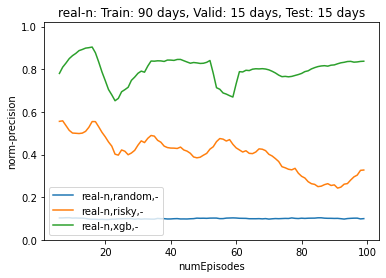

In [15]:
draw(prefix=prefix, metric='norm-precision', dataset='real-n')

['real-n,random,-', 'real-n,risky,-', 'real-n,xgb,-']
The number of trials for each setting (Results are averaged):
real-n,random,- 3 0.0993
real-n,risky,- 3 0.3273
real-n,xgb,- 3 0.8377


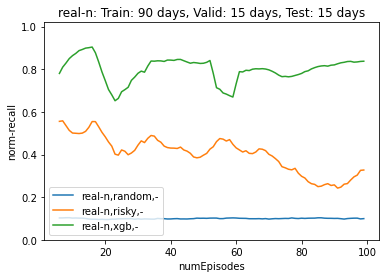

In [16]:
draw(prefix=prefix, metric='norm-recall', dataset='real-n')

['real-n,random,-', 'real-n,risky,-', 'real-n,xgb,-']
The number of trials for each setting (Results are averaged):
real-n,random,- 3 0.1048
real-n,risky,- 3 0.4673
real-n,xgb,- 3 0.7163


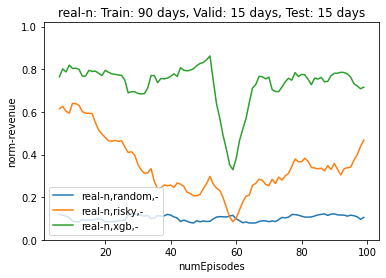

In [17]:
draw(prefix=prefix, metric='norm-revenue', dataset='real-n')

### real-t results (Performance: risky > xgb > random)

['real-t,random,-', 'real-t,risky,-', 'real-t,xgb,-']
The number of trials for each setting (Results are averaged):
real-t,random,- 3 0.102
real-t,risky,- 3 0.481
real-t,xgb,- 3 0.0848


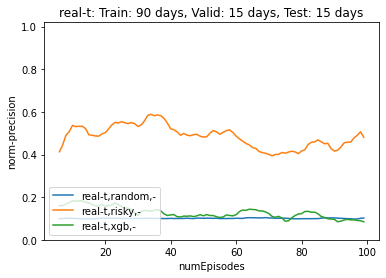

In [18]:
draw(prefix=prefix, metric='norm-precision', dataset='real-t')

['real-t,random,-', 'real-t,risky,-', 'real-t,xgb,-']
The number of trials for each setting (Results are averaged):
real-t,random,- 3 0.102
real-t,risky,- 3 0.481
real-t,xgb,- 3 0.0848


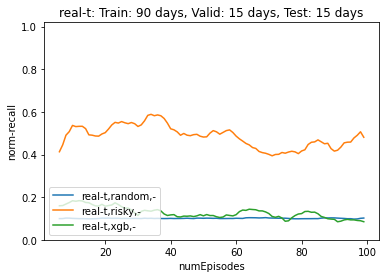

In [19]:
draw(prefix=prefix, metric='norm-recall', dataset='real-t')

['real-t,random,-', 'real-t,risky,-', 'real-t,xgb,-']
The number of trials for each setting (Results are averaged):
real-t,random,- 3 0.0988
real-t,risky,- 3 0.6654
real-t,xgb,- 3 0.068


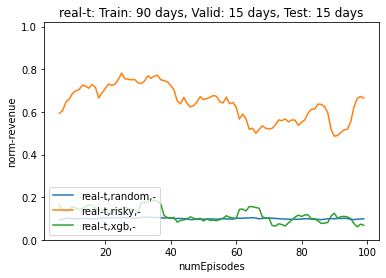

In [20]:
draw(prefix=prefix, metric='norm-revenue', dataset='real-t')

['real-t,risky,-']
The number of trials for each setting (Results are averaged):
real-t,risky,- 3 0.5778


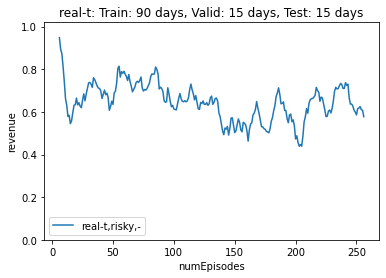

In [21]:
draw(prefix='ada', metric='revenue', dataset='real-t')